In [336]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import re
import ast
from collections import defaultdict
from tqdm import tqdm

## Opening anaylsis

In [284]:
player_to_analyze = "peterchero"

In [252]:
cm = pd.read_csv("full_combined_games_data.csv", parse_dates=True)

### Convert tags to numerical values

In [255]:
cm["Event"] = cm["Event"].replace({"Casual": 0, "Rated": 1})

In [257]:
def get_player_result(row):
    if row['Result'] == '1-0':
        if row['White'] == player:
            return 1  # Player won as White
        elif row['Black'] == player:
            return 0  # Player lost as Black
    elif row['Result'] == '0-1':
        if row['Black'] == player:
            return 1  # Player won as Black
        elif row['White'] == player:
            return 0  # Player lost as White
    elif row['Result'] == '1/2-1/2':
        return 0.5  # Draw
    else:
        return None  # Undefined result

cm['Result'] = cm.apply(get_player_result, axis=1)

In [259]:
def get_event_type(row):
    if type(row['Event']) == int:
        return row['Event']
    if "Casual" in row['Event']:
        return 0
    else:
        return 1
cm['Event'] = cm.apply(get_event_type, axis=1)

In [261]:
competetive_games = cm[cm["Event"] == 1]

In [263]:
allOpenings = cm['ECO'].value_counts().to_dict()

### Convert ECO to opening names

In [266]:
file = open('eco_codes.txt')
ECO_codes = file.read()

def parse_eco_codes(inputfile):
    eco_dict = {}
    lines = inputfile.strip().split('\n')
    for line in lines:
        # Use regex to match lines starting with an ECO code followed by a tab and the opening name
        match = re.match(r'^([A-E][0-9]{2})\t(.+)$', line)
        if match:
            eco_code = match.group(1)
            opening_name = match.group(2)
            eco_dict[eco_code] = opening_name
    return eco_dict

# Example: Translate an ECO code to its opening name
def eco_to_opening(row):
    eco_code = row['ECO']
    opening_name = eco_codes_dict.get(eco_code, "Unknown ECO code")
    return opening_name

# Parse the input text
eco_codes_dict = parse_eco_codes(ECO_codes)

cm['Opening'] = cm['ECO']
cm['Opening'] = cm.apply(eco_to_opening, axis = 1)

### Plotting data

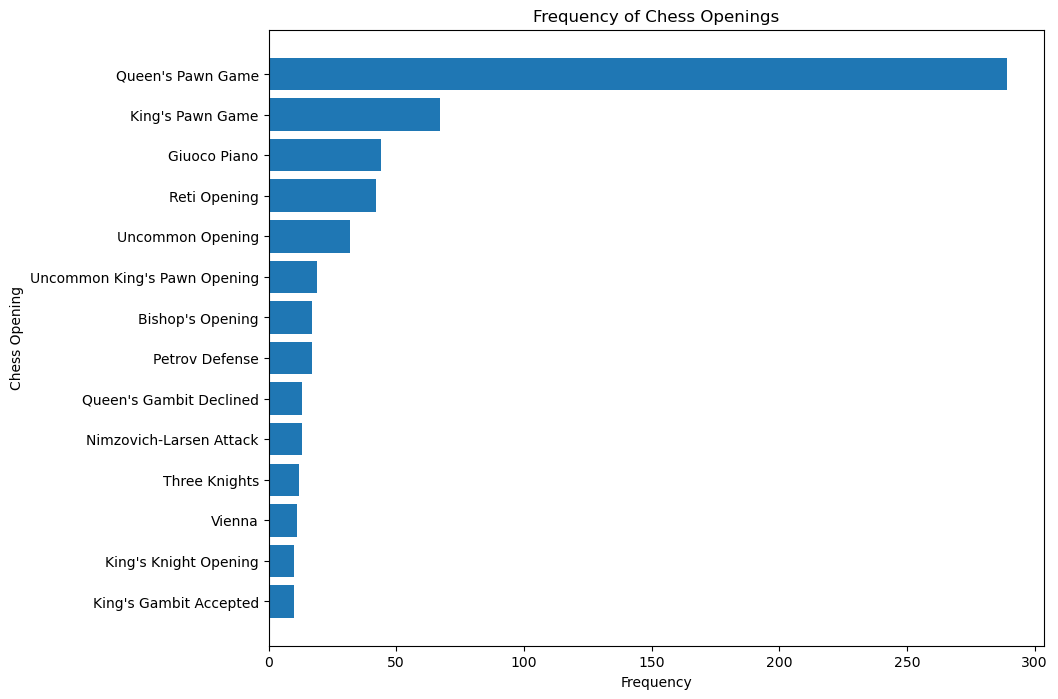

In [269]:
allOpenings = cm['Opening'].value_counts().to_dict()

min_instances = 10

filtered_openings = dict(
    filter(lambda item: min_instances <= int(item[1]), allOpenings.items())
)


openings = np.array(list(filtered_openings.keys()))
frequencies = np.array(list(filtered_openings.values()))

# Sort data by frequency for better visualization
sorted_indices = np.argsort(frequencies)
openings = openings[sorted_indices]
frequencies = frequencies[sorted_indices]

# Plot the bar chart
plt.figure(figsize=(10, 8))
plt.barh(openings, frequencies)
plt.xlabel('Frequency')
plt.ylabel('Chess Opening')
plt.title('Frequency of Chess Openings')
plt.show()

In [271]:
allOpenings.keys()

total_count = sum(allOpenings.values())
opening_percentages = {opening: (count / total_count) * 100 for opening, count in allOpenings.items()}

'''
openings = np.array(list(opening_percentages.keys()))
frequencies = np.array(list(opening_percentages.values()))

# Sort data by frequency for better visualization

sorted_indices = np.argsort(frequencies)
openings = openings[sorted_indices]
frequencies = frequencies[sorted_indices]

# Plot the bar chart

plt.figure(figsize=(10, 8))
plt.barh(openings, frequencies)
plt.xlabel('Frequency')
plt.ylabel('Chess Opening')
plt.title('Frequency of Chess Openings')
plt.show()
'''

"\nopenings = np.array(list(opening_percentages.keys()))\nfrequencies = np.array(list(opening_percentages.values()))\n\n# Sort data by frequency for better visualization\n\nsorted_indices = np.argsort(frequencies)\nopenings = openings[sorted_indices]\nfrequencies = frequencies[sorted_indices]\n\n# Plot the bar chart\n\nplt.figure(figsize=(10, 8))\nplt.barh(openings, frequencies)\nplt.xlabel('Frequency')\nplt.ylabel('Chess Opening')\nplt.title('Frequency of Chess Openings')\nplt.show()\n"

In [273]:
cm

,Event,Site,Date,White,Black,Result,WhiteElo,BlackElo,ECO,Opening,Termination,Moves,Evaluation
0,0,https://lichess.org/RQIN3TSF,2023.01.01,SciFiCarrot,peterchero,1.0,892,1306,A01,Nimzovich-Larsen Attack,Time forfeit,"['b2b3', 'b8c6', 'c1b2', 'g8f6', 'e2e3', 'e7e5...","[{'player': 'White', 'move_number': 1, 'move':..."
1,0,https://lichess.org/ppGi5xYt,2024.07.02,peterchero,Julia_11,1.0,1415,1500,A43,Old Benoni,Normal,"['d2d4', 'c7c5', 'd4c5', 'd8a5', 'c2c3', 'b8a6...","[{'player': 'White', 'move_number': 1, 'move':..."
2,1,https://lichess.org/7sJtGv4P,2023.02.23,Jasper2003,peterchero,0.0,1161,1067,C25,Vienna,Normal,"['e2e4', 'e7e5', 'b1c3', 'b8c6', 'f1c4', 'g7g6...","[{'player': 'White', 'move_number': 1, 'move':..."
3,0,https://lichess.org/BlRZYsba,2023.01.25,MoDi2233,peterchero,0.0,1500,1066,C44,King's Pawn Game,Normal,"['e2e4', 'e7e5', 'g1f3', 'b8c6', 'c2c3', 'f8c5...","[{'player': 'White', 'move_number': 1, 'move':..."
4,0,https://lichess.org/SBXD224s,2024.06.14,peterchero,li4nosTb,1.0,1507,1612,A41,Queen's Pawn Game (with ...d6),Normal,"['d2d4', 'd7d6', 'g1f3', 'c7c6', 'g2g3', 'b8d7...","[{'player': 'White', 'move_number': 1, 'move':..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,0,https://lichess.org/3MYmAq1i,2023.01.27,jool,peterchero,0.0,1605,1322,C45,Scotch Game,Normal,"['e2e4', 'e7e5', 'g1f3', 'b8c6', 'd2d4', 'e5d4...","[{'player': 'White', 'move_number': 1, 'move':..."
768,0,https://lichess.org/dRgzPe27,2024.07.14,peterchero,simal60,0.0,1415,1330,A46,Queen's Pawn Game,Time forfeit,"['d2d4', 'g8f6', 'g1f3', 'd7d6', 'g2g3', 'c8f5...","[{'player': 'White', 'move_number': 1, 'move':..."
769,0,https://lichess.org/7y0DqVTw,2023.01.19,kaCzmi120,peterchero,1.0,803,1100,C20,King's Pawn Game,Normal,"['e2e4', 'e7e5', 'd1h5', 'g8f6', 'h5e5', 'f8e7...","[{'player': 'White', 'move_number': 1, 'move':..."
770,1,https://lichess.org/BMmd0zaE,2023.01.25,Bizaman,peterchero,0.0,1157,1132,B00,Uncommon King's Pawn Opening,Normal,"['e2e4', 'e7e5', 'd2d4', 'b8c6', 'd4d5', 'c6b8...","[{'player': 'White', 'move_number': 1, 'move':..."


## Move evaluation

In [18]:
import chess#https://github.com/niklasf/python-chess
from stockfish import Stockfish

#We'll create an intentionally worse stockfish engine to estimate complexity of positions
stockfish=Stockfish("/opt/homebrew/bin/stockfish")
stockfish.set_depth(15)#How deep the AI looks
stockfish.set_skill_level(20)#Highest rank stockfish

In [19]:



games = []
gamenum = 0

for game in cm['Moves']:
    centipawn_losses = []
    print(str(gamenum+1) + " " + cm['Site'][gamenum] + " " + cm['White'][gamenum] + " " + cm['Black'][gamenum] )
    # print(cm['Moves'][gamenum])
    gamenum+=1
    game = ast.literal_eval(game)
    for i in range(len(game)):
        # Set the position before the current move
        stockfish.set_position(game[:i])
        eval_before = stockfish.get_evaluation()
    
    # Set the position after the current move
        stockfish.set_position(game[:i+1])
        eval_after = stockfish.get_evaluation()
    
        # Function to extract score
        def get_score(eval_dict):
            if eval_dict['type'] == 'cp':
                return eval_dict['value']
            elif eval_dict['type'] == 'mate':
                # Assign a centipawn value based on the number of moves to mate
                mate_in = eval_dict['value']
                score = "#" +str(mate_in)
                return score
            else:
                return None
        
        score_before = get_score(eval_before)
        score_after = get_score(eval_after)
        
        # Calculate centipawn loss
        if score_before is not None and score_after is not None:
            if type(score_before) == str or type(score_after) == str:
                if i % 2 == 0:  # White's move
                    centipawn_loss = score_before - score_after
                else:  # Black's move
                    centipawn_loss = score_after - score_before
            else:
                centipawn_loss = score_before
        else:
            centipawn_losses.append(None)
        centipawn_losses.append(centipawn_loss)
    games.append(centipawn_losses)
    print(centipawn_losses)


1 https://lichess.org/RQIN3TSF SciFiCarrot peterchero
[53, 41, 44, 70, 68, 18, 7, 74, 110, 176, 194, 294, 227, 299, 33, 47, 35, 6, 250, 16, 11, 2, -15, 158, 100, 71, 208, -20]
2 https://lichess.org/ppGi5xYt peterchero Julia_11
[6, 45, 51, 77, 34, 119, 25, 283, 362, 346, 332, 315, 274, 467, 288, 35, 74, 324, -6, -38, -22, 141, 0, -6, 30, 135, 110, -19, -5, -21, -6, 111, 65, -22, 120, 54, 55, 30413, 30347, 30347, 30035, 30035, 31000]
3 https://lichess.org/7sJtGv4P Jasper2003 peterchero
[-5, 7, 16, 1, 23, 44, -17, 10, 11, 7, -2, -4, 1, 21, 28, 169, 123, 73, 41, 252, 46, 171, 1, 57, 80, 115, 26, 244, -3, 27, 14, -38, 158, 171, 49, 28, 2, -6, -8, 20, 0, 41, 30, 52, 50, 113, 79, 87, -21, -71, -35, 5, 209, -84, -51, 25, -22, 173, -26, -12, -19, 27052, 28000, 27000, 29000, 26000, 26954, 57, -23897, 25000, 26000, 27000, 28000, 28000, 31000, 30000, 31000, 30000, 30000, 30000, 30000, 31000, 31000, 29000, 30000, 31000, 31000]
4 https://lichess.org/BlRZYsba MoDi2233 peterchero
[-5, 7, 5, -4, 44, 99

KeyboardInterrupt: 

## Move interpretation

### Move Bucketing

In [275]:
#cms = pd.read_csv("full_combined_games_data.csv")
#cms

**We can group our data so that the CPL of a given move can evaluated in comparison to the CPL of other games at that same move. Given this, we can understand weak points in our game. For example, move 1 would be hard to mess up on, since there are very few mistakes to be had at the first move of a chess game, so we should expect there to be a lower average CPL on move 1 of our game.**

In [286]:
white_move_bucket = defaultdict(int)
white_move_count = defaultdict(int)
black_move_bucket = defaultdict(int)
black_move_count = defaultdict(int)

player_move_bucket = defaultdict(int)
player_move_count = defaultdict(int)


for game in range(len(cm)):
    # Your list of dictionaries (move evaluations)
    evaluations = cm['Evaluation'][game]
    evaluations = ast.literal_eval(evaluations)
    
    # Initialize variables to accumulate centipawn losses
    white_total_cpl = 0
    black_total_cpl = 0
    
    # Initialize counters for the number of moves
    white_moves = 0
    black_moves = 0
    
    # Loop through each move evaluation
    for move_eval in evaluations:
        player = move_eval['player']
        centipawn_loss = move_eval['centipawn_loss']
        move_number = move_eval['move_number']
        move = move_eval['move']
        best_move = move_eval['best_move']
        player_eval = move_eval['player_evaluation']
        best_eval = move_eval['best_evaluation']
    
        # Process data as needed
        if player == 'White':
            white_total_cpl += centipawn_loss
            white_move_bucket[white_moves+1] += centipawn_loss
            white_move_count[white_moves+1] += 1
            white_moves += 1
            if player_to_analyze == cm['White'][game]:
                player_move_bucket[white_moves+1] += centipawn_loss
                player_move_count[white_moves+1] += 1
        else:
            black_total_cpl += centipawn_loss
            black_move_bucket[black_moves+1] += centipawn_loss
            black_move_count[black_moves+1] += 1
            black_moves += 1
            if player_to_analyze == cm['Black'][game]:
                player_move_bucket[black_moves+1] += centipawn_loss
                player_move_count[black_moves+1] += 1
        # Print or store information as needed
        print(f"Move {move_number}: {player} played {move}, best was {best_move}, CPL: {centipawn_loss}")
        
    
    # Calculate average centipawn loss per player
    white_avg_cpl = white_total_cpl / white_moves if white_moves > 0 else 0
    black_avg_cpl = black_total_cpl / black_moves if black_moves > 0 else 0
    
    print(f"\nTotal centipawn loss for White: {white_total_cpl}")
    print(f"Total centipawn loss for Black: {black_total_cpl}")
    print(f"Average centipawn loss for White: {white_avg_cpl:.2f}")
    print(f"Average centipawn loss for Black: {black_avg_cpl:.2f}\n")

Move 1: White played b2b3, best was e2e4, CPL: 63
Move 2: Black played b8c6, best was e7e5, CPL: 34
Move 3: White played c1b2, best was d2d4, CPL: 41
Move 4: Black played g8f6, best was e7e5, CPL: 55
Move 5: White played e2e3, best was g1f3, CPL: 46
Move 6: Black played e7e5, best was e7e5, CPL: 5
Move 7: White played f1b5, best was g1f3, CPL: 3
Move 8: Black played f8c5, best was d8e7, CPL: 85
Move 9: White played g1f3, best was b5c6, CPL: 131
Move 10: Black played d8e7, best was e5e4, CPL: 173
Move 11: White played e1g1, best was b5c6, CPL: 188
Move 12: Black played d7d5, best was e5e4, CPL: 277
Move 13: White played b1c3, best was f3e5, CPL: 240
Move 14: Black played d5d4, best was e5e4, CPL: 294
Move 15: White played e3d4, best was e3d4, CPL: 0
Move 16: Black played e5d4, best was e5d4, CPL: 2
Move 17: White played c3a4, best was c3a4, CPL: 0
Move 18: Black played e8g8, best was e8g8, CPL: 5
Move 19: White played c2c3, best was b5c6, CPL: 240
Move 20: Black played d4c3, best was d4

In [226]:
total_move_bucket = defaultdict(int)
total_move_count = defaultdict(int)

for move_number in white_move_bucket:
    total_move_bucket[move_number] += white_move_bucket[move_number]
    total_move_count[move_number] += white_move_count[move_number]

for move_number in black_move_bucket:
    total_move_bucket[move_number] += black_move_bucket[move_number]
    total_move_count[move_number] += black_move_count[move_number]

In [313]:
# For White
print("Average Centipawn Loss per Move for White:")
for move_number in sorted(white_move_bucket.keys()):
    avg_cpl = white_move_bucket[move_number] / white_move_count[move_number]
    num_instances = white_move_count[move_number]
    print(f"Move {move_number}: {avg_cpl:.2f} with a total of {num_instances} appearances")

# For Black
print("\nAverage Centipawn Loss per Move for Black:")
for move_number in sorted(black_move_bucket.keys()):
    avg_cpl = black_move_bucket[move_number] / black_move_count[move_number]
    num_instances = black_move_count[move_number]
    print(f"Move {move_number}: {avg_cpl:.2f} with a total of {num_instances} appearances")

# For Player we are anayzing
print("\nAverage Centipawn Loss per Move for " + player_to_analyze + ":")
for move_number in sorted(player_move_bucket.keys()):
    avg_cpl = player_move_bucket[move_number] / player_move_count[move_number]
    num_instances = player_move_count[move_number]
    print(f"Move {move_number}: {avg_cpl:.2f} with a total of {num_instances} appearances")

Average Centipawn Loss per Move for White:
Move 1: 8.41 with a total of 772 appearances
Move 2: 19.33 with a total of 767 appearances
Move 3: 29.06 with a total of 766 appearances
Move 4: 41.60 with a total of 764 appearances
Move 5: 42.49 with a total of 762 appearances
Move 6: 51.66 with a total of 757 appearances
Move 7: 65.69 with a total of 753 appearances
Move 8: 72.36 with a total of 748 appearances
Move 9: 81.86 with a total of 741 appearances
Move 10: 89.75 with a total of 734 appearances
Move 11: 79.85 with a total of 722 appearances
Move 12: 88.12 with a total of 709 appearances
Move 13: 82.75 with a total of 691 appearances
Move 14: 82.68 with a total of 678 appearances
Move 15: 81.09 with a total of 660 appearances
Move 16: 77.43 with a total of 642 appearances
Move 17: 87.44 with a total of 623 appearances
Move 18: 93.21 with a total of 607 appearances
Move 19: 89.67 with a total of 589 appearances
Move 20: 90.51 with a total of 574 appearances
Move 21: 104.96 with a tota

**ELO Rating estimation for Humans = 3100(e^(-0.01(Average Centipawn Loss))).**

In [370]:
def plotRating(move_count,move_bucket,min_move_thresh,player):
    move_numbers = sorted(player_move_bucket.keys())
    avg_cpl = [3100*math.pow(2.71828,-0.01*(move_bucket[mn] / move_count[mn])) for mn in move_numbers if move_count[mn] >= min_move_thresh]
    plt.plot([mn + 1 for mn in move_numbers if move_count[mn] >= min_move_thresh], avg_cpl, label=player)
    
def plotCPL(move_count,move_bucket,min_move_thresh,player):
    move_numbers = sorted(player_move_bucket.keys())
    avg_cpl = [move_bucket[mn] / move_count[mn] for mn in move_numbers if move_count[mn] >= min_move_thresh]
    plt.plot([mn + 1 for mn in move_numbers if move_count[mn] >= min_move_thresh], avg_cpl, label=player)

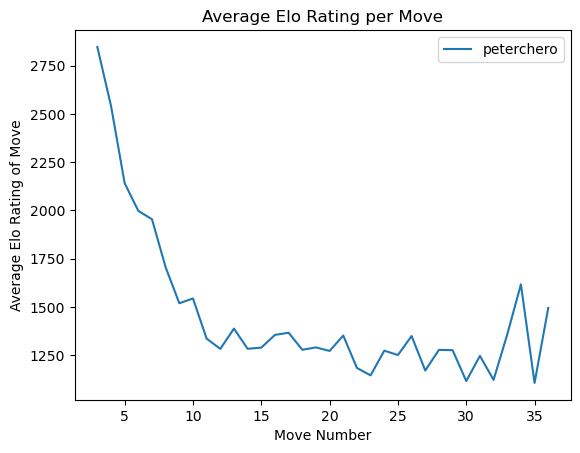

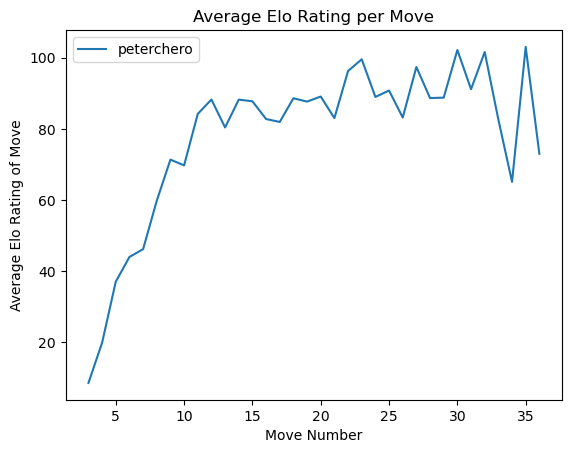

In [380]:
plotRating(player_move_count,player_move_bucket,250,player_to_analyze)
plotCPL(player_move_count,player_move_bucket,250,player_to_analyze)